In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))
from collections import defaultdict, Counter
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
sns.set_palette(colorcycle)
mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['figure.figsize'] = [12, 7]

import json

import networkx as nx
import missingno as msno
%matplotlib inline

from speclib.loaders import loadUser, loadUserPhonenumberDict, getUserList, Useralias
from speclib.plotting import looseAxesLimits


In [2]:
def linkUser(userDct, linkDctLst, phDct):
    """Links users in the project with each other.
    
    Args:
        userDct (dict): Dictionary with sms and call entries.
        linkDctLst (defaultdict(Counter)): Defaultdict with counter-factory
                                           to provide history.
        phDct (dict): Dictionary with phoneID -> userID for participants in the project.
        
    Returns:
        (float, float): Fraction of (calls, sms) to participants in the project.
    """
    def updateDict(commLst, linkDct, numberIndexStr):
        inProjectCEvent = 0  # initialize counter
        # Loop over communication events
        if commLst is None:
            return None
        for event in commLst:
            contactedNumber = event[numberIndexStr]
            user = event["user"]
            if contactedNumber in phDct:  # if number belongs to a participant in the project
                inProjectCEvent += 1
                contactedUser = phDct[contactedNumber]
                # Remember: it's a counter inside the defaultdict
                linkDct[user][contactedUser] += 1
        return inProjectCEvent

    # for call, index to phone number is "number", for sms it's "address"
    numberTypePairTuple = (("call", "number"), ("sms", "address"))
    inProjectFractions = list()  # Count communications to participants
    # Three indexes: ("call"/"sms"), ("number"/"address"), (associated defaultdict()
    for (commType, numberIndexStr), linkDct in zip(numberTypePairTuple, linkDctLst):
        count = updateDict(userDct[commType], linkDct, numberIndexStr)
        # Turn counts info fraction of communication between participants
        if count is None:
            inProjectFractions.append(None)
            continue
        try:
            inProjectFractions.append(count / len(userDct[commType]))
        except ZeroDivisionError:
            inProjectFractions.append(None)
    return inProjectFractions

Load all users and get fraction of communications made to people in the study.

In [3]:
phDct = loadUserPhonenumberDict()
userLst = getUserList()

callDct, smsDct = defaultdict(Counter), defaultdict(Counter)

smsFracArr = np.zeros(len(userLst))
callFracArr = np.zeros(len(userLst))
for i, user in enumerate(userLst):
    try:
        userDct = loadUser(user, dataFilter=("call", "sms"))
        callFrac, smsFrac = linkUser(userDct, (callDct, smsDct), phDct)
        callFracArr[i] = callFrac
        smsFracArr[i] = smsFrac
        if i % 50 == 0:
            print("{:.0f} %".format(100 * i / len(userLst)), end="\t")
    except Exception as e:
        print("\n\n\nSomething went wrong  at (user, index):\n", user, i)
        raise e
print("100 %")

0 %	5 %	9 %	14 %	19 %	24 %	28 %	33 %	38 %	42 %	47 %	52 %	57 %	61 %	66 %	71 %	75 %	80 %	85 %	90 %	94 %	99 %	100 %


In [15]:
def aliasUsernames(commDct, useralias):
    """Convert human unreadable user names to sequentially generated aliases.
    Will also convert the dict[Counter] to dict[dict].
    
    Args:
        commDct (dict): Dict with dicts of communication events (call or sms)
        useralias (Class instance): An instance of the Useralias class.
        Used for generating and formatting the aliases.
    
    Returns:
        dict[dict]: Like the input, but with uliases for all usernames.
    """
    outDct = dict()
    for ko, vo in commDct.items():
        kon = useralias[ko]
        inner = dict()
        for ki, vi in vo.items():
            inner[useralias[ki]] = vi
        outDct[kon] = inner
    return outDct


ua = Useralias()
callDct2 = aliasUsernames(callDct, ua)
smsDct2 = aliasUsernames(smsDct, ua)

***Cell below is new***

In [16]:
ttmp = pd.DataFrame(callDct2).replace(np.NaN, 0).astype(int)

ttmp.head() 

,u0001,u0002,u0003,u0004,u0005,u0006,u0007,u0008,u0009,u0010,...,u0769,u0770,u0771,u0772,u0773,u0775,u0776,u0777,u0778,u0779
u0001,0,12,32,3,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
u0002,4,1,23,5,0,0,42,0,0,0,...,0,0,0,0,0,0,0,0,0,0
u0003,15,17,3,39,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
u0004,1,8,49,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
u0005,0,0,0,0,2,3,0,16,3,2,...,0,0,0,0,0,0,0,0,0,0


In [17]:
callFracArr = callFracArr[np.logical_not(np.isnan(callFracArr))]
idx = np.argsort(callFracArr)[::-1]
callFracArr = callFracArr[idx]
smsFracArr = smsFracArr[idx]

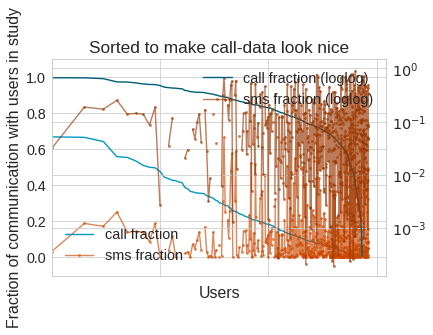

In [18]:
colorFun = lambda rgb: [el/255 for el in rgb]
callFracColorNormal = colorFun([2, 154, 196])
callFracColorLog = colorFun([1, 95, 121])
smsFracColorNormal = colorFun([204, 71, 0])
smsFracColorLog = colorFun([153, 54, 0])
fig, ax0 = plt.subplots()
ax0.plot(callFracArr, color=callFracColorNormal, label="call fraction")
ax0.plot(smsFracArr, '.-', color=smsFracColorNormal, label="sms fraction", alpha=0.65)
ax1 = plt.twinx(ax0)
ax1.loglog(callFracArr, color=callFracColorLog, label="call fraction (loglog)")
ax1.loglog(smsFracArr, '.-', color=smsFracColorLog, label="sms fraction (loglog)", alpha=0.65)
ax0.set_ylabel("Fraction of communication with users in study")
ax0.set_xlabel('Users')
ax0.set_xticklabels([])
ax0.set_title("Sorted to make call-data look nice")
looseAxesLimits(ax0)
ax0.legend(loc="lower left")
ax1.legend(loc="upper right") 

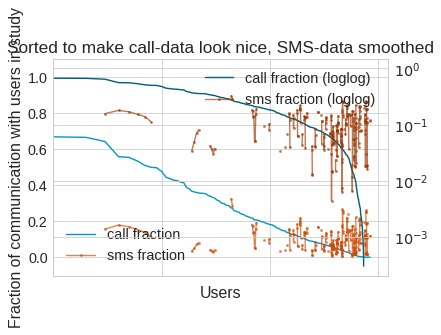

In [19]:
colorFun = lambda rgb: [el/255 for el in rgb]
callFracColorNormal = colorFun([2, 154, 196])
callFracColorLog = colorFun([1, 95, 121])
smsFracColorNormal = colorFun([204, 71, 0])
smsFracColorLog = colorFun([153, 54, 0])
fig, ax0 = plt.subplots()
ax0.plot(callFracArr, color=callFracColorNormal, label="call fraction")
ax0.plot(np.convolve(np.ones(5)/5, smsFracArr, 'same'), '.-',
         color=smsFracColorNormal, label="sms fraction", alpha=0.65)
ax1 = plt.twinx(ax0)
ax1.loglog(callFracArr, color=callFracColorLog, label="call fraction (loglog)")
ax1.loglog(np.convolve(np.ones(5)/5, smsFracArr, 'same'), '.-',
           color=smsFracColorLog, label="sms fraction (loglog)", alpha=0.65)
ax0.set_ylabel("Fraction of communication with users in study")
ax0.set_xlabel('Users')
ax0.set_xticklabels([])
ax0.set_title("Sorted to make call-data look nice, SMS-data smoothed")
looseAxesLimits(ax0)
ax0.legend(loc="lower left")
ax1.legend(loc="upper right") 

In [33]:
cdf = pd.DataFrame.from_dict(callDct2, orient="index").apply(lambda x: x/np.sum(x))  # Normalize
sdf = pd.DataFrame.from_dict(smsDct2, orient="index").apply(lambda x: x/np.sum(x))
cmb = pd.concat((cdf, sdf))
cmb = cmb.groupby(cmb.index).sum()
cmb.head(25)

,u0001,u0002,u0003,u0004,u0005,u0006,u0007,u0008,u0009,u0010,...,u0795,u0796,u0797,u0798,u0799,u0801,u0803,u0807,u0808,u0809
u0001,NaN,0.149038,0.313048,0.003584,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0002,0.785211,0.019050,0.618757,0.035851,NaN,NaN,1.602248,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0003,0.997653,0.351610,0.097292,0.230651,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0004,0.196303,0.068688,0.715659,0.006774,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0005,NaN,NaN,NaN,NaN,0.052632,0.038106,0.178613,0.311905,0.004961,0.026861,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0006,NaN,NaN,NaN,NaN,0.237281,NaN,NaN,NaN,NaN,0.821543,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0007,NaN,1.315965,NaN,NaN,0.058333,NaN,NaN,0.083135,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0008,NaN,NaN,NaN,NaN,0.971053,NaN,0.041490,0.087897,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0009,NaN,NaN,NaN,NaN,0.095614,NaN,NaN,NaN,0.010293,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0010,NaN,NaN,NaN,NaN,0.077632,0.528236,NaN,NaN,NaN,0.006165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The data is quite sparse. It's hard to see, but there's a black dot when the data i _not_ `NaN`.

First plot is for calls, second for SMS.

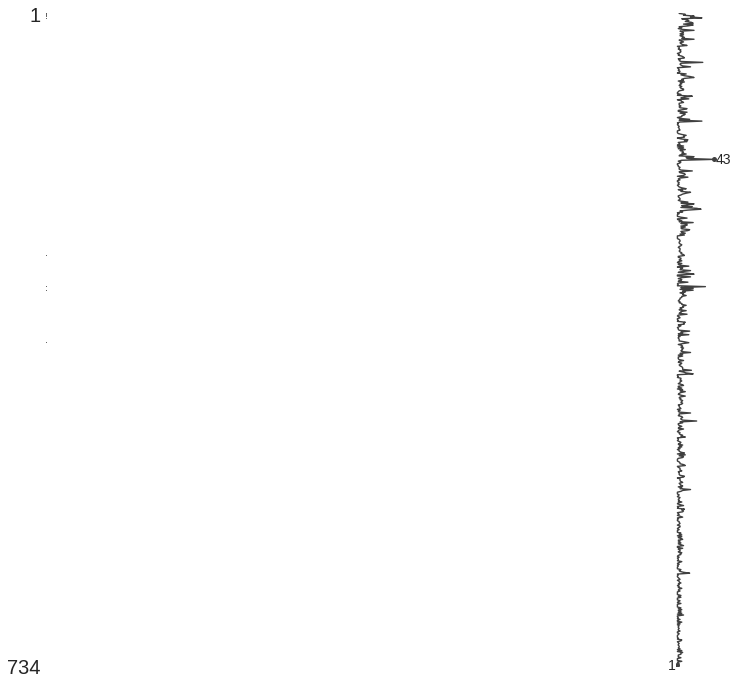

In [29]:
msno.matrix(cdf, figsize=(12, 12))

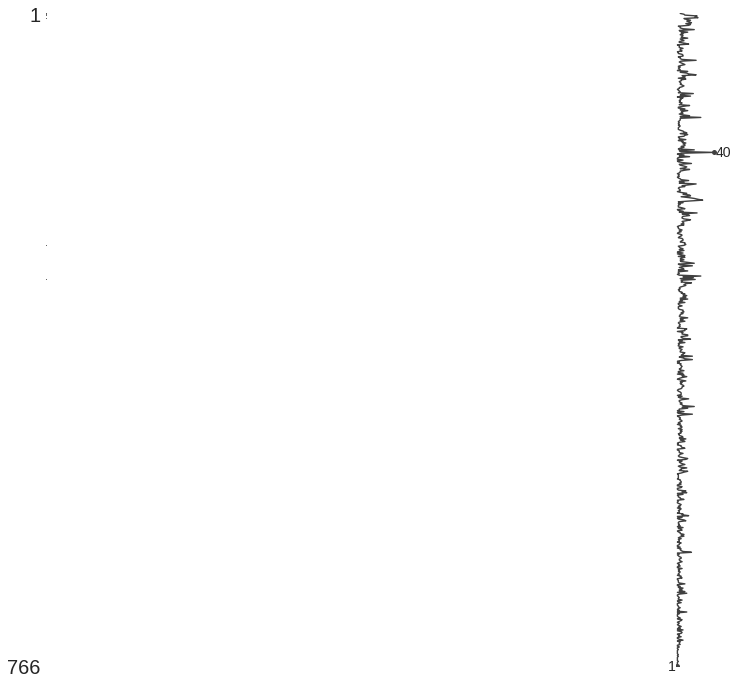

In [30]:
msno.matrix(sdf, figsize=(12, 12))

Adjacency matrix excluding telephone numbers which is not part of the Social Fabric study.

In [31]:
g = nx.from_dict_of_lists({k:callDct[k].keys() for k in callDct})

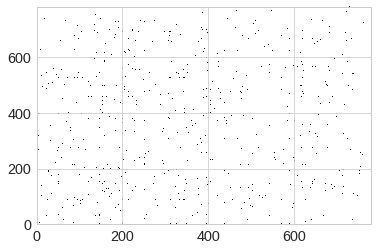

In [32]:
gm = nx.adjacency_matrix(g)
fig, ax = plt.subplots()
ax.pcolorfast(gm.todense())